In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize, LabelEncoder, MinMaxScaler, OneHotEncoder

from sklearn import linear_model, metrics, model_selection, preprocessing, tree
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC



## 导入、查看数据集

In [2]:
data = pd.read_csv("loan.csv")
data.shape

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260668, 145)

In [3]:
data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN






## 处理数据集中的缺失值
#### 查看数据集中有多少空值

In [4]:
data.isnull().sum()

id                                            2260668
member_id                                     2260668
loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
installment                                         0
grade                                               0
sub_grade                                           0
emp_title                                      166969
emp_length                                     146907
home_ownership                                      0
annual_inc                                          4
verification_status                                 0
issue_d                                             0
loan_status                                         0
pymnt_plan                                          0
url                         

#### 有些特征的值大多为空，它们是难以处理或者无用的；

#### 所以删除掉数据集中，缺失数量大于1%的特征；

In [5]:
cleaned_data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]]
cleaned_data.isnull().sum()

loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
home_ownership                   0
annual_inc                       4
verification_status              0
issue_d                          0
loan_status                      0
pymnt_plan                       0
purpose                          0
zip_code                         1
addr_state                       0
dti                           1711
delinq_2yrs                     29
earliest_cr_line                29
inq_last_6mths                  30
open_acc                        29
pub_rec                         29
revol_bal                        0
revol_util                    1802
total_acc                       29
initial_list_status              0
out_prncp                        0
out_prncp_inv       

#### 有三种方式清理掉这些空值
  *删除行空值；
  *填充中值或模式值；
  *或使用一些填充并尝试预测缺失的值；
  
#### 这里我们直接删除行空值

In [6]:
cleaned_data = cleaned_data.dropna()
cleaned_data.shape

(2253339, 50)

In [7]:
cleaned_data.shape[0] / data.shape[0]

0.9967580378896858

可见，我们保留了99%以上的行数


## 删除数据集中的没用的特征

In [8]:
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,...,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,RENT,55000.0,...,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,MORTGAGE,90000.0,...,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,MORTGAGE,59280.0,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,MORTGAGE,92000.0,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,MORTGAGE,57250.0,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N


当前特征中，“zip_code”与“addr_state”相比是多余的，且只有3位数可见，无用，删除；
根据https://www.lendingclub.com/public/rates-and-fees.action ，特征“sub_grade”是多余的，删除；


#### 删除掉没用的两个特征

In [9]:
cleaned_data = cleaned_data.drop(["sub_grade", "zip_code"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,...,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,...,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,...,1,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N




#### 查看只有少数值的特征

In [10]:
for label in list(cleaned_data):
    if len(cleaned_data[label].unique()) < 5:
        print(cleaned_data[label].value_counts())
        print("\n")

 36 months    1604204
 60 months     649135
Name: term, dtype: int64


Source Verified    884549
Not Verified       740891
Verified           627899
Name: verification_status, dtype: int64


n    2252660
y        679
Name: pymnt_plan, dtype: int64


w    1531323
f     722016
Name: initial_list_status, dtype: int64


1    2253339
Name: policy_code, dtype: int64


Individual    2134713
Joint App      118626
Name: application_type, dtype: int64


N    2252458
Y        881
Name: hardship_flag, dtype: int64


Cash         2175369
DirectPay      77970
Name: disbursement_method, dtype: int64


N    2220376
Y      32963
Name: debt_settlement_flag, dtype: int64




可见，特征“pymnt_plan”只有两个可能的值:“n”和“y”，但是“y”只出现了10次(少于1%)，显然它是不重要的，删除；
特性“policy_code”只有一个可能的值，因此它对我们完全没有用处，删除；
类似地，接下来我们删除掉其它没用的特征；


#### 删除没用的几个特征

In [11]:
cleaned_data = cleaned_data.drop(["pymnt_plan", "policy_code", "application_type", "hardship_flag",
                                  "disbursement_method", "debt_settlement_flag"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,2500,2500,2500.0,36 months,13.56,84.92,C,RENT,55000.0,Not Verified,...,0.0,Feb-2019,84.92,Feb-2019,0.0,0.0,0.0,0.0,1.0,0.0
1,30000,30000,30000.0,60 months,18.94,777.23,D,MORTGAGE,90000.0,Source Verified,...,0.0,Feb-2019,777.23,Feb-2019,0.0,0.0,0.0,0.0,1.0,0.0
2,5000,5000,5000.0,36 months,17.97,180.69,D,MORTGAGE,59280.0,Source Verified,...,0.0,Feb-2019,180.69,Feb-2019,0.0,0.0,0.0,0.0,0.0,0.0
3,4000,4000,4000.0,36 months,18.94,146.51,D,MORTGAGE,92000.0,Source Verified,...,0.0,Feb-2019,146.51,Feb-2019,0.0,0.0,0.0,0.0,0.0,0.0
4,30000,30000,30000.0,60 months,16.14,731.78,C,MORTGAGE,57250.0,Not Verified,...,0.0,Feb-2019,731.78,Feb-2019,0.0,0.0,0.0,0.0,0.0,0.0




#### 删除日期时间和total pymnt特征
一般来说，日期时间等特征是非常难以处理的，需要删除掉；
在实际的贷款业务中，我们无法提前从新客户处得到“total_pymnt”信息，这是“无法得到”的特征，需要删除掉；

In [12]:
cleaned_data = cleaned_data.drop(["total_pymnt", "total_pymnt_inv", "last_pymnt_d", "earliest_cr_line", "issue_d", "last_credit_pull_d"], axis=1) # data
cleaned_data.shape

(2253339, 36)

In [13]:
cleaned_data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,...,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06,2.253339e+06
mean,1.504935e+04,1.504415e+04,1.503005e+04,1.308758e+01,4.458302e+02,7.805344e+04,1.883249e+01,3.067546e-01,5.757500e-01,1.162292e+01,...,1.461654e+00,1.349380e+02,2.242579e+01,3.370173e+03,1.815972e-02,4.148954e-03,8.462109e-03,1.233406e+01,1.283171e-01,4.684692e-02
std,9.185825e+03,9.183971e+03,9.184898e+03,4.829104e+00,2.670083e+02,1.127745e+05,1.415806e+01,8.668933e-01,8.805047e-01,5.638096e+00,...,1.150466e+01,7.209786e+02,1.264419e+02,5.975358e+03,1.508479e-01,6.963405e-02,1.047876e-01,7.249315e+02,3.647891e-01,3.777738e-01
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,-9.500000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.517500e+02,4.600000e+04,1.191000e+01,0.000000e+00,0.000000e+00,8.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.094500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.295000e+04,1.290000e+04,1.280000e+04,1.262000e+01,3.781500e+02,6.500000e+04,1.784000e+01,0.000000e+00,0.000000e+00,1.100000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,5.897500e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.932200e+02,9.300000e+04,2.450000e+01,0.000000e+00,1.000000e+00,1.400000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,3.553820e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,1.700000e+01,1.010000e+02,...,1.427250e+03,3.985955e+04,7.174719e+03,4.219205e+04,2.000000e+01,1.400000e+01,1.000000e+01,2.499250e+05,1.200000e+01,8.500000e+01




## 根据贷款状态设置标签
贷款有多个可能的不同状态，包括Fully paid、Current、Late、In grace period、Charge off等等；

对于建立预测模型的任务而言，贷款状态为“Current”的数据是无用的，我们不知道它们是否会被成功地偿还，它只作为预测任务的预测对象，所以删掉；

为建立分类模型，我们将贷款状态处理为：如果贷款状态为“Fully Paid”，即全部偿还，我们将其分配为类别1；如果贷款处于其他任何状态我们则将其分配为类别0；

这个类别将作为预测模型的输出变量，是我们试图预测的对象；

In [14]:
cleaned_data = cleaned_data[cleaned_data["loan_status"] != "Current"]
cleaned_data["y"] = np.where(cleaned_data["loan_status"] == "Fully Paid", 1, 0)
cleaned_data = cleaned_data.drop("loan_status", axis=1)
cleaned_data.shape

(1335920, 36)



## One-hot 编码
我们对所有特征值进行one-hot编码，因为预测模型通常只适用于严格的数值数据

In [15]:
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,y
100,30000,30000,30000.0,36 months,22.35,1151.16,D,MORTGAGE,100000.0,Source Verified,...,0.0,0.0,30082.32,0.0,0.0,0.0,0.0,1.0,0.0,1
152,40000,40000,40000.0,60 months,16.14,975.71,C,MORTGAGE,45000.0,Verified,...,0.0,0.0,40910.48,0.0,0.0,0.0,0.0,0.0,0.0,1
170,20000,20000,20000.0,36 months,7.56,622.68,A,MORTGAGE,100000.0,Not Verified,...,0.0,0.0,20228.39,0.0,0.0,0.0,0.0,0.0,0.0,1
186,4500,4500,4500.0,36 months,11.31,147.99,B,RENT,38500.0,Not Verified,...,0.0,0.0,4553.46,0.0,0.0,0.0,0.0,0.0,0.0,1
215,8425,8425,8425.0,36 months,27.27,345.18,E,MORTGAGE,450000.0,Verified,...,0.0,0.0,8754.30,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
dummy_variables = ["term","grade", "home_ownership", "verification_status", "purpose", "addr_state",
                   "initial_list_status"]
# dummy_variables = ["issue_month", "emp_length", "term", "grade", "home_ownership", "purpose", "addr_state", "application_type", "disbursement_method"]
data_dummies = pd.get_dummies(cleaned_data[dummy_variables])
data_dummies.shape

(1335920, 85)

In [17]:
data_notime = pd.concat([cleaned_data, data_dummies], axis=1)
data_notime = data_notime.drop(dummy_variables, axis=1)
data_notime.shape

(1335920, 114)



## 数据归一化和相关性分析
#### 首先我们应该将各变量的尺度归一化，使各预测模型的权重更合适地进行比较

In [18]:
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,y
100,30000,30000,30000.0,36 months,22.35,1151.16,D,MORTGAGE,100000.0,Source Verified,...,0.0,0.0,30082.32,0.0,0.0,0.0,0.0,1.0,0.0,1
152,40000,40000,40000.0,60 months,16.14,975.71,C,MORTGAGE,45000.0,Verified,...,0.0,0.0,40910.48,0.0,0.0,0.0,0.0,0.0,0.0,1
170,20000,20000,20000.0,36 months,7.56,622.68,A,MORTGAGE,100000.0,Not Verified,...,0.0,0.0,20228.39,0.0,0.0,0.0,0.0,0.0,0.0,1
186,4500,4500,4500.0,36 months,11.31,147.99,B,RENT,38500.0,Not Verified,...,0.0,0.0,4553.46,0.0,0.0,0.0,0.0,0.0,0.0,1
215,8425,8425,8425.0,36 months,27.27,345.18,E,MORTGAGE,450000.0,Verified,...,0.0,0.0,8754.30,0.0,0.0,0.0,0.0,0.0,0.0,1


In [19]:
scaler = MinMaxScaler()
variables_to_normalize = ["loan_amnt", "funded_amnt", "funded_amnt_inv","int_rate","installment", 
                          "annual_inc", "dti", "delinq_2yrs", "inq_last_6mths","open_acc", "pub_rec","revol_bal", "revol_util",
                          "total_acc", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
                           "last_pymnt_amnt", "collections_12_mths_ex_med", "acc_now_delinq", "chargeoff_within_12_mths",
                          "delinq_amnt", "pub_rec_bankruptcies", "tax_liens"]
data_notime[variables_to_normalize] = scaler.fit_transform(data_notime[variables_to_normalize])

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



#### 以下用seaborn生成热图来展现变量之间的相互关系

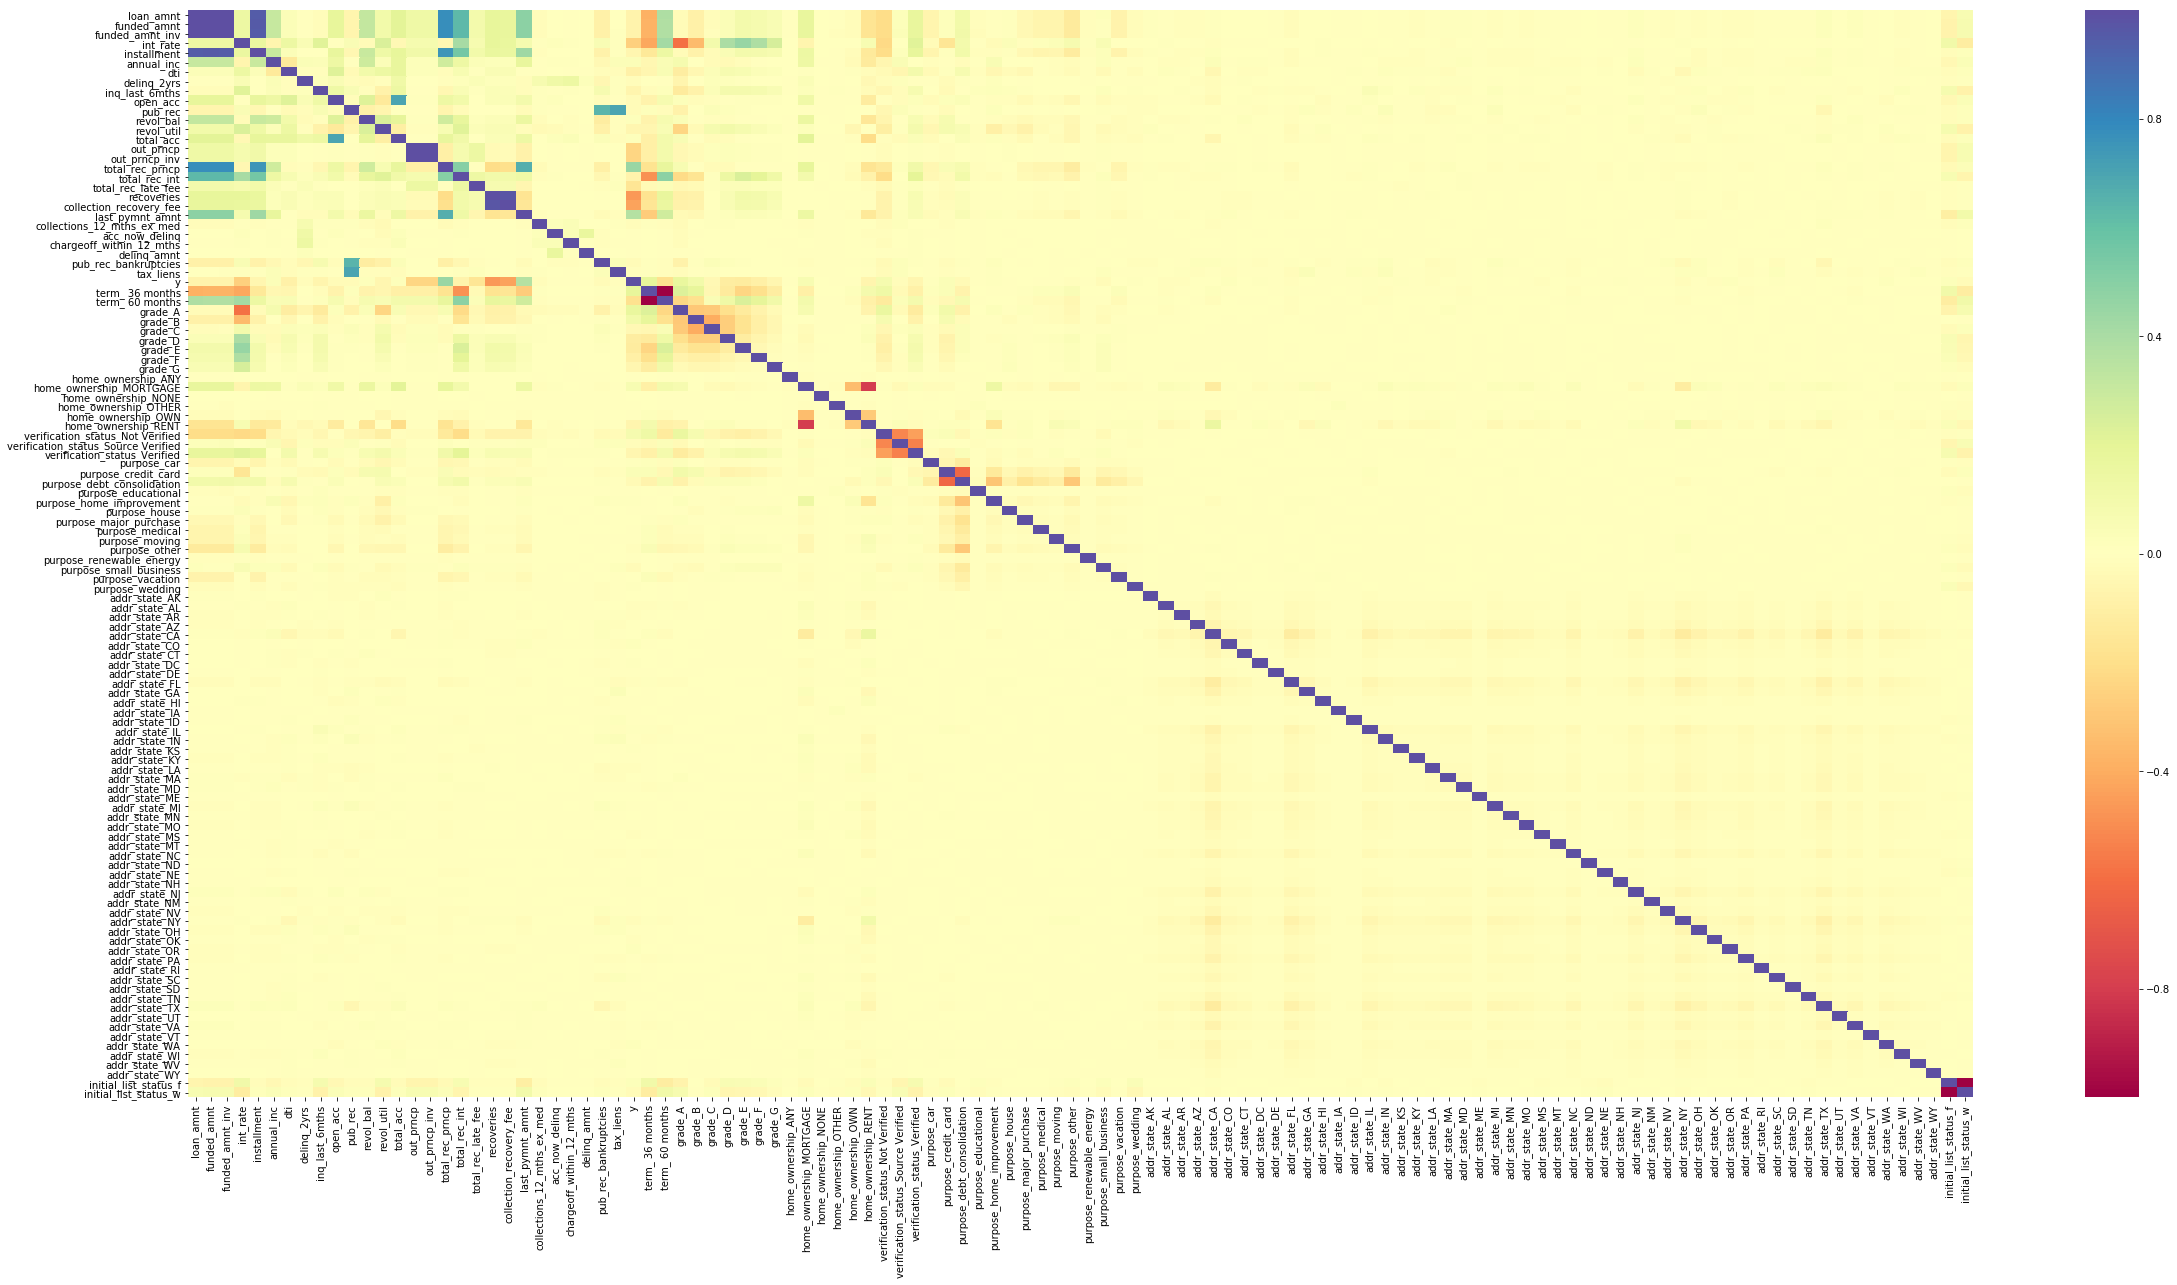

In [20]:
corr = data_notime.corr()
fig, ax = plt.subplots(figsize=(40, 20)) 
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap="Spectral", ax=ax)



## 生成用于模型训练与评价的数据集

In [21]:
data_select = data_notime.iloc[0:40000, :]
data_select.shape

(40000, 114)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215684F3588>]],
      dtype=object)

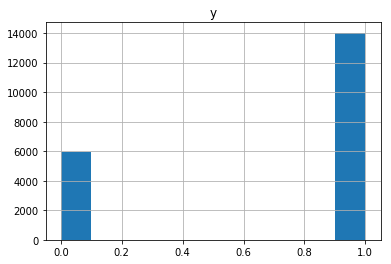

In [22]:
length_data = data_select.shape[0]
data_train = data_select.iloc[0:length_data:2, :]
y_train = data_train.y
x_train = data_train.drop(["y"], axis=1)
data_train.hist(column='y')

In [23]:
data_train.shape

(20000, 114)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215AB203DA0>]],
      dtype=object)

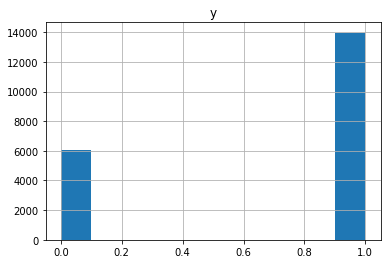

In [ ]:
data_test = data_select.iloc[1:length_data:2, :]
y_test = data_test.y
x_test = data_test.drop(["y"], axis=1)
data_test.hist(column='y')

In [ ]:
data_test.shape

(20000, 114)



## 建立预测模型，并在测试集上进行测试

In [ ]:
# Logistic Regression

model_logr = LogisticRegression().fit(x_train, y_train)
acc_train_logr = round(model_logr.score(x_train, y_train) * 100, 2)

test_pred_logr = model_logr.predict(x_test)
acc_test_logr = round(metrics.accuracy_score(y_test, test_pred_logr) * 100, 2)

print("Accuracy of LogisticRegression on trainset:", acc_train_logr)
print("Accuracy of LogisticRegression on testset:", acc_test_logr)

Accuracy of LogisticRegression on trainset: 90.84
Accuracy of LogisticRegression on testset: 90.28


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# Stochastic Gradient Descent
model_sgd = SGDClassifier().fit(x_train, y_train)
acc_train_sgd = round(model_sgd.score(x_train, y_train) * 100, 2)

test_pred_sgd = model_sgd.predict(x_test)
acc_test_sgd = round(metrics.accuracy_score(y_test, test_pred_sgd) * 100, 2)

print("Accuracy of Stochastic Gradient Descent on trainset:", acc_train_sgd)
print("Accuracy of Stochastic Gradient Descent on testset:", acc_test_sgd)

Accuracy of Stochastic Gradient Descent on trainset: 99.12
Accuracy of Stochastic Gradient Descent on testset: 98.95


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [ ]:
# K-Nearest Neighbors

model_knn = KNeighborsClassifier().fit(x_train, y_train)
acc_train_knn = round(model_knn.score(x_train, y_train) * 100, 2)

test_pred_knn = model_knn.predict(x_test)
acc_test_knn = round(metrics.accuracy_score(y_test, test_pred_knn) * 100, 2)

print("Accuracy of K-Nearest Neighbors on trainset:", acc_train_knn)
print("Accuracy of K-Nearest Neighbors on testset:", acc_test_knn)

Accuracy of K-Nearest Neighbors on trainset: 95.3
Accuracy of K-Nearest Neighbors on testset: 93.51


In [ ]:
# Decision Tree

model_dt = DecisionTreeClassifier().fit(x_train, y_train)
acc_train_dt = round(model_dt.score(x_train, y_train) * 100, 2)

test_pred_dt = model_dt.predict(x_test)
acc_test_dt = round(metrics.accuracy_score(y_test, test_pred_dt) * 100, 2)

print("Accuracy of Decision Tree on trainset:", acc_train_dt)
print("Accuracy of Decision Tree on testset:", acc_test_dt)

Accuracy of Decision Tree on trainset: 100.0
Accuracy of Decision Tree on testset: 99.72


In [ ]:
# Random Forests

model_rf = RandomForestClassifier(n_estimators=400, max_depth=2, random_state=0).fit(x_train, y_train)
acc_train_rf = round(model_rf.score(x_train, y_train) * 100, 2)

test_pred_rf = model_rf.predict(x_test)
acc_test_rf = round(metrics.accuracy_score(y_test, test_pred_rf) * 100, 2)

print("Accuracy of Random Forests on trainset:", acc_train_rf)
print("Accuracy of Random Forests on testset:", acc_test_rf)

Accuracy of Random Forests on trainset: 91.51
Accuracy of Random Forests on testset: 91.07


In [ ]:
# Multi-layer Perceptron

mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1,activation='logistic')
mlp.fit(x_train, y_train)
print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_test, y_test))
print(mlp.classes_)

Iteration 1, loss = 0.43647726
Iteration 2, loss = 0.22412511
Iteration 3, loss = 0.11230772
Iteration 4, loss = 0.05998447
Iteration 5, loss = 0.04092929
Iteration 6, loss = 0.03209016
Iteration 7, loss = 0.02688487
Iteration 8, loss = 0.02382608
Iteration 9, loss = 0.02173255
Iteration 10, loss = 0.01978374
Iteration 11, loss = 0.01873729
Iteration 12, loss = 0.01768891
Iteration 13, loss = 0.01699831
Iteration 14, loss = 0.01629354
Iteration 15, loss = 0.01587294
Iteration 16, loss = 0.01546570
Iteration 17, loss = 0.01505623
Iteration 18, loss = 0.01456334
Iteration 19, loss = 0.01432054
Iteration 20, loss = 0.01436510
Iteration 21, loss = 0.01364938
Iteration 22, loss = 0.01374090
Iteration 23, loss = 0.01340987
Iteration 24, loss = 0.01326663
Iteration 25, loss = 0.01310651
Iteration 26, loss = 0.01293315
Iteration 27, loss = 0.01273670
Iteration 28, loss = 0.01245226
Iteration 29, loss = 0.01251807
Iteration 30, loss = 0.01241373
Iteration 31, loss = 0.01226749
Iteration 32, los

In [ ]:
# SVM

model_svm = SVC().fit(x_train, y_train)
acc_train_svm = round(model_svm.score(x_train, y_train) * 100, 2)

test_pred_svm = model_svm.predict(x_test)
acc_test_svm = round(metrics.accuracy_score(y_test, test_pred_svm) * 100, 2)

print("Accuracy of SVM on trainset:", acc_train_svm)
print("Accuracy of SVM on testset:", acc_test_svm)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### 从以上运行结果可以看到，多层感知器在测试集上取得了最高的准确率，达到了99.75%；
#### 第二名是决策树，在测试集上的准确率为99.72%；